In [ ]:
# gerekli paketlerin import edilmesi
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

DIRECTORY = r"/content/drive/MyDrive/Colab Notebooks/BitirmeProjesi2/dataset"
CATEGORIES = ["with_mask", "without_mask"]

In [ ]:
# veri setimizde bulunan resimler için liste oluşturalım
print("-> Resimler yükleniyor...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

-> Resimler yükleniyor...


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
# train ve test ayrimi
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [ ]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [ ]:
# MobileNetV2 ile base model olusturulmasi
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# üzerine gelecek olan modelin head kismininin olusturulmasi
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# egitilecek asil modelin olusturulmasi
model = Model(inputs=baseModel.input, outputs=headModel)

# temel modeldeki tum katmanlar uzerinde dongu yapip ilk train asamasindaki guncellenmeyi onluyoruz
for layer in baseModel.layers:
	layer.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
# modelin derlenmesi
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# train
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
95/95 [==============================] - 90s 916ms/step - loss: 0.4083 - accuracy: 0.8484 - val_loss: 0.1772 - val_accuracy: 0.9622
Epoch 2/20
95/95 [==============================] - 87s 916ms/step - loss: 0.1505 - accuracy: 0.9628 - val_loss: 0.0994 - val_accuracy: 0.9700
Epoch 3/20
95/95 [==============================] - 87s 909ms/step - loss: 0.0938 - accuracy: 0.9763 - val_loss: 0.0755 - val_accuracy: 0.9778
Epoch 4/20
95/95 [==============================] - 86s 904ms/step - loss: 0.0738 - accuracy: 0.9802 - val_loss: 0.0628 - val_accuracy: 0.9765
Epoch 5/20
95/95 [==============================] - 86s 909ms/step - loss: 0.0631 - accuracy: 0.9845 - val_loss: 0.0550 - val_accuracy: 0.9778
Epoch 6/20
95/95 [==============================] - 87s 911ms/step - loss: 0.0549 - accuracy: 0.9829 - val_loss: 0.0539 - val_accuracy: 0.9765
Epoch 7/20
95/95 [==============================] - 87s 910ms/step - loss: 0.0484 - accuracy: 0.9871 - val_loss: 0.046

In [ ]:
# test asamasinda tahminlerde bulunacagiz
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


In [ ]:
# test kumesindeki her goruntu icin, karsilik gelen en buyuk tahmini olasiliga sahip etiketin dizinini buluyoruz
predIdxs = np.argmax(predIdxs, axis=1)

In [ ]:
# siniflandirma icin rapor
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.98      0.99      0.99       383
without_mask       0.99      0.98      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



In [ ]:
# modelin kaydedilmesi
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

[INFO] saving mask detector model...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


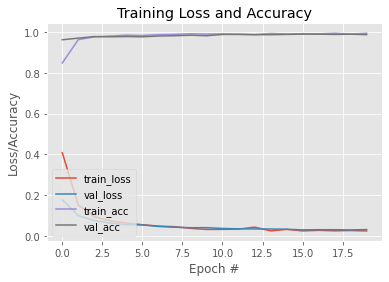

In [ ]:
# train icin loss ve accuracy degerleri
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")